# Análise Comparativa de Modelos

Nesse notebook iremos olhar para os textos obtidos na primeira unidade para construir modelos de aprendizado de máquina. Para isso, precisaremos de algumas bibliotecas já conhecidas (*pandas, nltk, numpy*) e de outras novas, relacionadas à:
- preparação dos dados: 
    - *CountVectorizer*, 
    - *TfidfVectorizer*,
    - *TruncatedSVD*
    - *StandardScaler*
- aprendizagem em si: 
    - *LogisticRegression*, 
    - *KNeighborsClassifier*, 
    - *SVC*, 
    - *RandomForestClassifier*
- construção da sequência de passos a realizar:
    - *Pipeline*
- avaliação e seleção dos modelos obtidos:
    - *ShuffleSplit*,
    - *cross_validate*
    
Algumas dessas funções serão explicadas adiante. Sigamos.

## Importando bibliotecas

In [1]:
%reload_ext autoreload
%autoreload 2

from functools import partial
import joblib
import pickle
from src.data import organize
from itertools import product # produto cartesiano de duas listas sem precisar de for aninhados
import pandas as pd # manipulação de dataframes
import nltk # ferramentas p/ processamento de linguagem natural
import numpy as np # manipulação de matrizes, funções matemáticas
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (
    ShuffleSplit, KFold, cross_validate, RandomizedSearchCV
)

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /data/home/taynafiuza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Carregando Dados

In [2]:
# Adquire dados do arquivo produzido na etapa anterior
input_path = "../data/interim/news.csv"
df = pd.read_csv(input_path)

# Converte as colunas com texto em uma lista
corpus = df.text.to_list()

# Atribui codificação dos rótulos das notícias
#label_encoder = LabelEncoder()
#labels = label_encoder.fit_transform(df.label)
labels = df.label.replace({"true": 1, "fake": 0})

## Conversão dos textos (Vetorizadores)

### CountVectorizer

Esse método de conversão cria uma matriz com a contagem de todas as palavras presentes em todos os textos considerados. Esse método também é chamado de Bag of Words, ou Saco de Palavras.

![CountVectorizer](images/count-vectorizer.png)

### TfidfVectorizer

Esse método de conversão cria uma matriz que considera dois valores: TF e DF. TF ($tf_{i,j}$) é a contagem de uma palavra ($i$) no texto ($j$), tal como é calculada pelo CountVectorizer. Já DF ($df_{i}$) diz respeito à quantidade de textos em que aquela palavra aparece. No cálculo, o valor para uma dada palavra ($w_{i,j}$) é dado por:

$ w_{i,j} = tf_{i,j} \times log(\frac{N}{df_{i}}) $

Em que $N$ é o número total de documentos. Como $df_{i}$ está no denominador do logarítmo, trata-se de uma conversão que considera TF e o inverso de DF, iDF.

![CountVectorizer](images/tfidf-vectorizer.png)

Em ambos os casos, palavras comuns e sem importância semântica no idioma trabalhado devem ser removidas. Afinal, caso fossem consideradas na conversão TFiDF, as palavras "de" e "desse" no primeiro texto teriam o mesmo peso da palavra "corrupção" e "suspeito", com importância semântica superior.

Aqui, optamos também por utilizar apenas as 1000 palavras mais frequentes em ambas as conversões, de modo a limitar o número de características para o treinamento.

In [3]:
vectorizer = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

## Modelos de Aprendizagem de Máquina

### Regressão Logística

A regressão logística, que é um modelo classificador, utiliza uma função logística para calcular as probabilidades de uma notícia ser falsa ou verdadeira. A função logística por trás deste modelo é uma curva sigmoide contendo as probabilidades de classificação em uma determinada categoria (notícia falsa ou verdadeira). A partir disso se encontra um valor limite dentro da curva para que então se obtenham as predições.

### KNN

Aqui a classificação das notícias em falsas ou verdadeira é feita com base nos K-vizinhos mais próximos (*K-Nearest Neighbors*) a ela. Se utilizamos $K = 10$ e dentre as 10 notícias mais próximas de uma notícia $i$ no nosso espaço dimensional, 6 são falsas e 4 são verdadeiras, esta notícia $i$ será classificada como falsa.

### SVC

O SVC é um *Support Vector Classifier*, isso é, um algoritmo de classificação que utiliza vetores (dados) como suporte para definir um hiperplano que separe dados de um grupo dos dados de outro grupo. No nosso caso, o SVC busca um hiperplano que separe as matrizes produzidas a partir de notícias falsas daquelas de notícias verdadeiras.

O hiperplano pode ser obtido após uma transformação dos dados, na qual eles saem de seu espaço dimensional original, intrínseco, e são levados a um espaço dimensional superior. Essa transformação é feita através através de diversas fórmulas matemáticas para que então o hiperplano ideal - aquele que separa os dados com melhor margem - seja identificado; este é o chamado *kernel trick*.

### Random Forest

A *Random Forest*, uma floresta aleatória, é um método que faz uso de diversas Árvores de Decisão, *Decision Trees*. As árvores de decisão são aquelas que fazem sucessivas divisões nos dados utilizando as características disponíveis de modo a obter grupos que sejam o mais diferentes entre si e o mais coesos internamente. Exemplo de divisão para separação de grupos: textos que têm a palavra ministro e textos que não têm, textos contendo a palavra corrupção e textos que não tem.

Contando então com várias árvores de decisão, a *Floresta*, é um classificador do tipo *ensemble*, pois considera diferentes predições finais para cada texto pelas diferentes árvores. A predição prevalente para um dado texto é então incorporada à saída da *Random Forest*. Como as árvores de decisão não são dependentes entre si, possuindo critérios próprios e não relacionados, a Random Forest minimiza o viés que viria do uso de uma única árvore, se tornando um modelo poderoso.

## Busca em Grade

Para comparar os diversos modelos foi realizada uma busca em grade pelos melhores hiperparâmetros de cada modelo de acordo com o F1-Score. Para cada modelo foram identificados alguns hiperparâmetros e valores de referência com impacto no desempenho final, conforme atribuídos a seguir:

In [4]:
models = [{
    'name': 'LR',
    'model': LogisticRegression(solver='liblinear'),
    'parameters':{
        'penalty': ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 10),
    }
},{
    'name': 'KNN',
    'model': KNeighborsClassifier(algorithm='kd_tree'),
    'parameters': {
        'n_neighbors': np.arange(3, 21, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
},{
    'name': 'RF',
    'model': RandomForestClassifier(),
    'parameters':{
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'bootstrap': [True, False]
    },
},{
    'name': 'SVC',
    'model': SVC(max_iter=10000, gamma='auto', probability=True),
    'parameters':{
        "C": [1e-5, 1e-4, 1e-3, 1, 10, 100, 1000, 1e5]
    }
},{
        'name': 'GB',
        'model': GradientBoostingClassifier(),
        'parameters':{
            'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
            'min_samples_split': np.linspace(0.1, 0.5, 12),
            'min_samples_leaf': np.linspace(0.1, 0.5, 12),
            'max_depth':[3,5,8],
            'max_features':['log2','sqrt'],
            'criterion': ['friedman_mse',  'absolute_error'],
            'subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
            'n_estimators':[10]
    }
}]

## Redução de Dimensionalidade

Quando trabalhamos com texto é natural que o resultado das transformações dos textos em vetores (CountVectorizer, TFiDFVectorizer, etc) seja uma matriz esparsa, pois grande parte das palavras NÃO estará presente em diversos textos. Desse modo, pode ser vantajoso aplicar uma redução de dimensionalidade. Na etapa de transformação, ficamos com mil *features*, referentes às ocorrências das palavras mais frequentes. 

Agora, usaremos a função TruncatedSVD para reduzir nossa matriz esparsa pela metade, ficando apenas com as ocorrências das A palavras menos esparsas dentre as B mais frequentes. A decomposição em valores singulares (*singular value decomposition*, SVD) transforma a matriz recebida e a leva para um espaço dimensional menor, reduzindo o efeito de sinônimos e palavras similares, as quais são usadas de maneira alternada pelos textos.

## Normalização

Na normalização os valores são transformados de forma a escala das diferentes características, isso reduz as chances de superestimação ou subestimação de determinadas *features* em função de seus valores padrão. Aqui, foi empregada uma normalização do tipo Z ou padronização, que subtrai a média da distribuição do para cada valor e divide o resultado pelo desvio padrão para aquela característica. Essa é uma maneira de normalizar sem alterar a distribuição das features, seja qual for.

In [5]:
pca = TruncatedSVD()
scaler = StandardScaler()

## Conjuntos de dados



In [6]:
df = pd.read_csv('../data/processed/textos_pre-processados.csv')
df.sample(5)

,text,label,lemmatization_plus_stop_words,stemming_plus_stopwords,lemmatization_wo_stopwords,stemming_wo_stopwords
5281,"Cortella sobre o muro de Trump: ""Injustiça his...",fake,cortellar sobre o muro de trump injustiça hist...,cortell sobr o mur de trump injustiç histór mu...,cortellar sobre muro trump injustiça histórico...,cortell sobr mur trump injustiç histór mur ver...
7146,Corte no Bolsa Família para 2016 pode jogar 8 ...,fake,corte em o bolsa família para 2016 poder jogar...,cort no bols famíl par 2016 pod jog 8 milhã de...,corte bolso família 2016 poder jogar 8 milhão ...,cort bols famíl 2016 pod jog 8 milhã pesso pob...
2330,"Coreia do Norte dispara novos mísseis, confirm...",true,coreio de o norte disparar novo míssil confirm...,core do nort disp nov míssel confirm eua segun...,corear norte disparar novo míssil confirmar EU...,core nort disp nov míssel confirm eua segund c...
6980,Álvaro Dias  O único candidato à presidência ...,fake,álvaro dia  o único candidato a o presidência...,álvar dia  o únic candidat à presid que defen...,álvaro dia  único candidato presidência defen...,álvar dia  únic candidat presid defend fim fo...
5747,Filha de Dilma terá que devolver os 8 carrões ...,fake,filha de Dilma ter que devolver o 8 carrão bli...,filh de dilm ter que devolv os 8 carr blind e ...,filha dilmo devolver 8 carrão blindar 16 servi...,filh dilm devolv 8 carr blind 16 serv dispos p...


## Validação Cruzada

Para testar a robustez dos modelos, a validação cruzada foi feita sobre 10 divisões aleatórias dos dados, conservando 80% deles para o conjunto de treinamento e 20% para teste. Ao final, os escores de avaliação (acurácia, F1-score) obtidos foram armazenados em uma variável *results* para posterior análise.

### Acurácia

Esta medida de avaliação considera os acertos que o modelo realizou, sejam eles ao classificar notícias falsas como falsas ou notícias verdadeiras como verdadeiras. Todos os acertos são computados e calculados em forma de porcentagem em relação ao número total de dados. Esta é uma métrica interessante quando ambas as categorias são igualmente importantes.

### F1

No nosso caso, como detector de notícias falsas, pode ser mais interessante, caso seja necessário, priorizar modelos que tenham melhor desempenho em corretamente rotular notícias falsas. Nesse caso, o *F1-score* é uma boa medida para a avaliação dos erros (falsos positivos e falsos negativos) e será dado pela média harmônica entre precisão e sensibilidade. No nosso caso:

- Precisão
> Proporção dada pelo # de notícias falsas corretamente classificadas como falsas e o # total de notícias classificadas como falsas.
- Sensibilidade
> Proporção dada pelo # de notícias corretamente classificadas como falsas dividido pelo # notícias realmente falsas. 

In [7]:
n_splits_cv = 10
n_splits_cv_grid_search = 5
model_scores = []

dataset_names = ['text', 'lemmatization_plus_stop_words', 'stemming_plus_stopwords', 'lemmatization_wo_stopwords', 'stemming_wo_stopwords']
for dataset_name in dataset_names:
    corpus = df[dataset_name].to_list()
    #label_encoder = LabelEncoder()
    #labels = label_encoder.fit_transform(df.label)
    labels = df.label.replace({"true": 1, "fake": 0})
    for model in models:
        approach_name = f"{dataset_name}-{model['name']}"
        print(f"running {approach_name}")
        param_grid = {
            'vectorizer__tfidf__use_idf': [False, True],
            'vectorizer__count__max_features': [1000, 2000],
            'pca__n_components': [100, 200, 500],
            **{f"model__{key}": value for key, value in model['parameters'].items()}
        }
        approach = Pipeline([
            ("vectorizer", vectorizer),
            ("pca", pca),
            ("normalize", scaler),
            ('model', model['model'])
        ])

        gs = RandomizedSearchCV(
            estimator=approach,
            param_distributions=param_grid,
            scoring='f1',
            cv=n_splits_cv_grid_search,
            random_state=24
        )

        scores = cross_validate(
            estimator=gs,
            X=corpus,
            y=labels,
            cv=ShuffleSplit(n_splits=n_splits_cv, test_size=.2),
            n_jobs=35,
            scoring=['accuracy', 'precision', 'recall','f1', 'roc_auc'],
        )
        scores['model'] = [approach_name] * n_splits_cv
        model_scores.append(scores)

running text-LR
running text-KNN
running text-SVC
running text-RF
running lemmatization_plus_stop_words-LR


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtuale

running lemmatization_plus_stop_words-KNN
running lemmatization_plus_stop_words-SVC
running lemmatization_plus_stop_words-RF
running stemming_plus_stopwords-LR


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtuale

running stemming_plus_stopwords-KNN
running stemming_plus_stopwords-SVC
running stemming_plus_stopwords-RF
running lemmatization_wo_stopwords-LR
running lemmatization_wo_stopwords-KNN
running lemmatization_wo_stopwords-SVC
running lemmatization_wo_stopwords-RF
running stemming_wo_stopwords-LR
running stemming_wo_stopwords-KNN
running stemming_wo_stopwords-SVC
running stemming_wo_stopwords-RF


In [8]:
organize.save_object(model_scores, '../data/processed/model_scores.pkl')

## Comparação dos modelos
### Tabela

Em que os resultados são agrupados de acordo com os modelos e são calculadas média e desvio padrão dos M modelos gerados para cada combinação parâmetros, conjunto de dados e método de aprendizagem de máquina.

In [9]:
scores = organize.concatenate(*model_scores)

In [10]:
results = (
    pd
    .DataFrame(scores)
    .groupby(['model'])
    .agg([lambda x: f"{np.mean(x):.3f} ± {np.std(x):.3f}"])#
    .transpose()
    .reset_index()
    .rename(columns={"level_0": "score"})
    .drop(columns="level_1")    
)

Nesta tabela temos informações relacionadas a:
- **Fit Time**: Tempo gasto na adequação do modelo ao conjunto de treino.
- **Score Time**: Tempo gasto para avaliação do modelo com o conjunto teste.
- **Test Accuracy**: Acurácia do modelo frente ao conjunto teste.
- **Test F1**: F1 score do modelo frente ao conjunto teste.

As células que computam estas métricas em seu máximo valor estão coloridas.

### Figura

Para produzir a figura os dados provenientes dos resultados passaram por uma pequena modificação para que cada método de aprendizado e cada vetorizador ficasse em uma coluna específica.

In [11]:
results_df = (
    pd
    .DataFrame(scores)
)
results_df

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,model
0,821.853969,2.250186,0.952083,0.941497,0.963788,0.952512,0.986611,text-LR
1,852.746867,1.510833,0.950000,0.941094,0.957204,0.949081,0.989676,text-LR
2,871.174541,1.667850,0.951389,0.949509,0.952180,0.950843,0.989350,text-LR
3,852.364620,1.577384,0.960417,0.961696,0.960383,0.961039,0.988521,text-LR
4,834.534324,2.261811,0.951389,0.946058,0.956643,0.951321,0.987420,text-LR
...,...,...,...,...,...,...,...,...
595,2155.487590,1.167288,0.904861,0.928467,0.878453,0.902768,0.960873,stemming_wo_stopwords-RF
596,2205.132310,1.558663,0.916667,0.936416,0.895028,0.915254,0.974413,stemming_wo_stopwords-RF
597,2140.099336,1.512043,0.914583,0.939169,0.885315,0.911447,0.966686,stemming_wo_stopwords-RF
598,2133.297572,1.816486,0.920139,0.927273,0.913223,0.920194,0.969404,stemming_wo_stopwords-RF


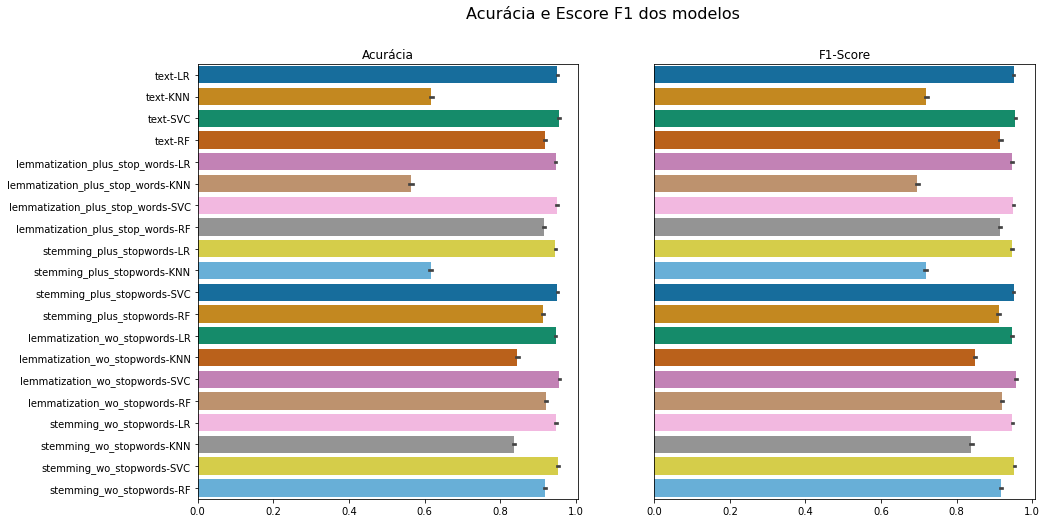

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
fig.suptitle('Acurácia e Escore F1 dos modelos', fontsize=16)

sns.barplot(x="test_accuracy", y="model", palette="colorblind",
            data=results_df, ax=ax1)
ax1.set_title("Acurácia")
ax1.set(xlabel=None, ylabel=None)

sns.barplot(x="test_f1", y="model", palette="colorblind",
            data=results_df, ax=ax2)
ax2.set_title("F1-Score")
ax2.set(xlabel=None, ylabel=None)
ax2.set_yticks([])

plt.show()

## Melhores resultados

### Conjunto de dados x tipo de modelo

In [13]:
time_scores = ['fit_time', 'score_time']
get_winner = partial(organize.get_winner, models=results.columns[1:])
winner = (
    results
    .query('score not in @time_scores')
    .apply(get_winner, axis=1)
    .value_counts()
    .index[0]
)
results.columns.name = ''
results = (
    results
    .style
    .hide(axis='index')
    .apply(organize.highlight_max, props='color:white;background-color:blue', axis=1)
)
display(results)
print(f'O melhor modelo é o {winner}')

score,lemmatization_plus_stop_words-KNN,lemmatization_plus_stop_words-LR,lemmatization_plus_stop_words-RF,lemmatization_plus_stop_words-SVC,lemmatization_wo_stopwords-KNN,lemmatization_wo_stopwords-LR,lemmatization_wo_stopwords-RF,lemmatization_wo_stopwords-SVC,stemming_plus_stopwords-KNN,stemming_plus_stopwords-LR,stemming_plus_stopwords-RF,stemming_plus_stopwords-SVC,stemming_wo_stopwords-KNN,stemming_wo_stopwords-LR,stemming_wo_stopwords-RF,stemming_wo_stopwords-SVC,text-KNN,text-LR,text-RF,text-SVC
fit_time,994.033 ± 66.359,1331.173 ± 211.385,2294.896 ± 40.314,1044.035 ± 43.945,930.980 ± 20.156,761.416 ± 37.668,2205.831 ± 54.228,1482.353 ± 66.510,1016.787 ± 81.687,995.716 ± 80.045,2308.192 ± 44.791,1164.840 ± 41.503,924.553 ± 41.516,780.211 ± 41.230,2207.477 ± 44.600,1499.178 ± 88.471,1001.587 ± 25.784,848.277 ± 23.508,2353.697 ± 50.039,1151.032 ± 44.183
score_time,8.264 ± 2.655,2.124 ± 0.622,1.962 ± 0.491,4.331 ± 1.575,8.346 ± 2.872,1.359 ± 0.419,1.658 ± 1.714,6.677 ± 2.597,7.333 ± 2.248,2.034 ± 0.495,1.820 ± 0.396,3.679 ± 1.255,7.528 ± 2.825,1.379 ± 0.361,1.423 ± 0.335,7.179 ± 3.557,7.771 ± 2.875,1.903 ± 0.445,2.118 ± 0.270,3.721 ± 1.490
test_accuracy,0.565 ± 0.015,0.947 ± 0.005,0.917 ± 0.008,0.950 ± 0.006,0.845 ± 0.011,0.947 ± 0.005,0.921 ± 0.006,0.957 ± 0.005,0.616 ± 0.012,0.946 ± 0.005,0.913 ± 0.008,0.951 ± 0.005,0.837 ± 0.010,0.947 ± 0.006,0.919 ± 0.008,0.953 ± 0.006,0.618 ± 0.013,0.951 ± 0.005,0.918 ± 0.008,0.956 ± 0.006
test_precision,0.536 ± 0.015,0.943 ± 0.007,0.924 ± 0.008,0.946 ± 0.011,0.829 ± 0.014,0.949 ± 0.007,0.943 ± 0.008,0.955 ± 0.007,0.565 ± 0.013,0.946 ± 0.008,0.927 ± 0.009,0.942 ± 0.008,0.826 ± 0.015,0.951 ± 0.007,0.936 ± 0.009,0.947 ± 0.010,0.567 ± 0.014,0.947 ± 0.007,0.930 ± 0.010,0.953 ± 0.010
test_recall,0.993 ± 0.003,0.952 ± 0.008,0.908 ± 0.012,0.955 ± 0.010,0.870 ± 0.014,0.944 ± 0.009,0.897 ± 0.010,0.959 ± 0.011,0.983 ± 0.005,0.947 ± 0.008,0.896 ± 0.013,0.961 ± 0.010,0.852 ± 0.015,0.944 ± 0.009,0.900 ± 0.013,0.959 ± 0.010,0.986 ± 0.005,0.955 ± 0.008,0.902 ± 0.011,0.958 ± 0.008
test_f1,0.696 ± 0.012,0.947 ± 0.005,0.916 ± 0.008,0.950 ± 0.006,0.849 ± 0.010,0.947 ± 0.005,0.919 ± 0.007,0.957 ± 0.005,0.718 ± 0.010,0.947 ± 0.005,0.911 ± 0.009,0.951 ± 0.005,0.839 ± 0.010,0.948 ± 0.006,0.918 ± 0.008,0.953 ± 0.006,0.720 ± 0.011,0.951 ± 0.006,0.916 ± 0.008,0.956 ± 0.006
test_roc_auc,0.853 ± 0.009,0.987 ± 0.003,0.974 ± 0.003,0.988 ± 0.002,0.923 ± 0.007,0.986 ± 0.003,0.974 ± 0.004,0.990 ± 0.002,0.889 ± 0.009,0.986 ± 0.002,0.974 ± 0.004,0.989 ± 0.003,0.914 ± 0.008,0.987 ± 0.003,0.972 ± 0.004,0.990 ± 0.002,0.895 ± 0.008,0.989 ± 0.002,0.977 ± 0.004,0.990 ± 0.002


O melhor modelo é o lemmatization_wo_stopwords-SVC


### Melhor hiperparâmetro para tal combinação

In [14]:
best_model = [item for item in models if item["name"] == winner.split("-")[-1]][0]
best_dataset_name = winner.split("-")[0]

corpus = df[best_dataset_name].to_list()
#label_encoder = LabelEncoder()
#labels = label_encoder.fit_transform(df.label)
labels = df.label.replace({"true": 1, "fake": 0})

param_grid = {
            'vectorizer__tfidf__use_idf': [False, True],
            'vectorizer__count__max_features': [1000, 2000],
            'pca__n_components': [100, 200, 500],
            **{f"model__{key}": value for key, value in best_model['parameters'].items()}
        }

approach = Pipeline([
    ("vectorizer", vectorizer),
    ("pca", pca),
    ("normalize", scaler),
    ('model', best_model['model'])
])

gs = RandomizedSearchCV(
    estimator=approach,
    param_distributions=param_grid,
    scoring='f1',
    cv=n_splits_cv_grid_search,
    random_state=24
)

gs.fit(corpus, labels)

best_estimator = gs.best_estimator_
best_estimator.fit(corpus, labels)

model_path = "../models/best_model.joblib"
joblib.dump(best_estimator, model_path)

/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['../models/best_label_encoder.joblib']